# Naive implementation of the dense XPCS correlator

The function describing the XPCS calculation are described in 
http://dx.doi.org/10.1063/1.1287637
Eq 16 contains the error propagation.

This notebook describes:
1. The generation of a syntetic qmask and dense XPCS dataset
2. The calculation of a CSR representation of qbin mask
3. The calculation the reference results using a simple kernel without atomic operation on the device
4. The calculation of XPCS dataset using workgroup-wide collective reduction.

The performances are not outperforming a good linear algebra with a parallel BLAS but it is easier to follow the loops in OpenCL.

In [1]:
%matplotlib notebook
from matplotlib.pyplot import subplots
import os, time, sys

## Qbin mask creation

In [2]:
import numpy
y,x = numpy.ogrid[-100:101,-120:121]
r = (x**2+y**2)**0.5
shape = r.shape
qbin = (r//10).astype(int)
shape

(201, 241)

<IPython.core.display.Javascript object>


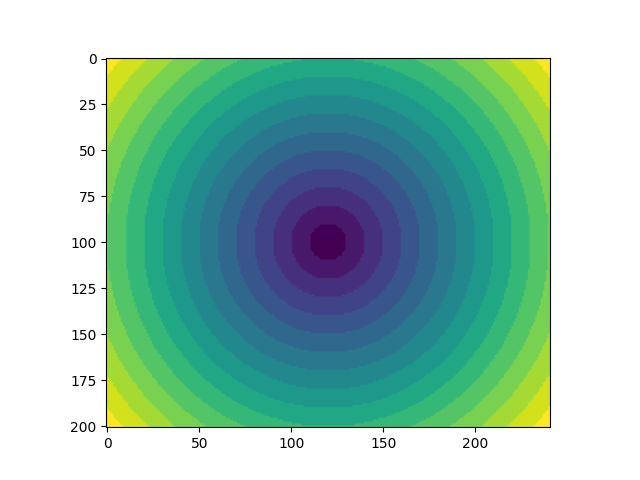

In [3]:
fig,ax = subplots(1, 1)
# ax[0].imshow(r)
_=ax.imshow(qbin)

## CSR representation of the Qbin mask

In [4]:
%%time
pixel_cnt = numpy.bincount(qbin.ravel())
mask_ptr = numpy.concatenate(([0], pixel_cnt.cumsum()))
nbins = qbin.max()+1
positions = numpy.arange(nbins)

CPU times: user 359 µs, sys: 158 µs, total: 517 µs
Wall time: 360 µs


In [5]:
%time
from scipy.sparse import csc_matrix
row = numpy.digitize(qbin.ravel(), positions)-1
size = row.size
col = numpy.arange(size)
dat = numpy.ones(size, dtype=float)
csc = csc_matrix((dat, (row, col)), shape = (nbins, size))
print(csc.shape)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs
(16, 48441)


In [6]:
%time csr = csc.tocsr()

CPU times: user 1.04 ms, sys: 453 µs, total: 1.5 ms
Wall time: 654 µs


In [7]:
csr.indices

array([22047, 22048, 22049, ..., 48438, 48439, 48440], dtype=int32)

## Creation of a fake XPCS dataset

In [8]:
nframes = 1000
stack = numpy.random.randint(0, 10, size = (nframes,)+shape).astype("uint8")

## Reference implementation based on numpy

In [9]:
from dynamix.correlator import dense
d=dense.MatMulCorrelator(shape, nframes, qmask=qbin)
%time res = d.correlate(stack, calc_std=True)

/users/kieffer/.venv/py39/lib/python3.9/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


CPU times: user 10 s, sys: 7.17 s, total: 17.2 s
Wall time: 1.88 s


# Implement dense correlator in OpenCL...

In [10]:
%load_ext pyopencl.ipython_ext

In [11]:
import pyopencl  as cl
from pyopencl import array as cla

ctx = cl.create_some_context(interactive=0)
queue = cl.CommandQueue(ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)

In [12]:
%%cl_kernel
/*Size if the kernel: dim0: qbin 
                      dim1: tau        
*/


kernel void correlator_multiQ_dense(
    const global char* frames,
    const global int* q_mask_ptr,
    const global int* q_mask_pixels,
    global float* output_mean,
    global float* output_std,
    const int Nt,
    const int image_size
) {
    uint qbin = get_global_id(0);
    uint tau = get_global_id(1);
    if (tau >= Nt) return;
    
    const int start = q_mask_ptr[qbin+1];
    const int stop = q_mask_ptr[qbin+2];
    ulong dia_n_val = 0;
    ulong dia_n_sum = 0;
    double dia_d_sum = 0.0;
    int npix = stop - start;
    double sumV = 0.0;
    double varV = 0.0;
    uint cnt = 0;
    for (uint t = tau; t < Nt; t++) {
        ulong sum1 = 0;
        ulong sum2 = 0;
        dia_n_val = 0;
        for (uint idx = start; idx < stop; idx++) {
            uint pix_idx = q_mask_pixels[idx];
            uint val1 = frames[t*image_size + pix_idx];
            uint val2 = frames[(t-tau)*image_size + pix_idx];
            dia_n_val += val1 * val2;
            sum1 += val1;
            sum2 += val2;
        }
        double dia_d_val = (sum1 * sum2 * 1.0) / (npix * npix);
        
        dia_n_sum += dia_n_val;
        dia_d_sum += dia_d_val;
        
        //Variance propagation
        double val = dia_n_val / (dia_d_val * npix);
        if (cnt>0){
            double num = sumV - cnt*val;
            varV += num*num/(cnt*(cnt+1));
        }
        sumV += val;        
        cnt++;
    }
    output_mean[qbin*Nt + tau] = dia_n_sum * 1.0 / (dia_d_sum * npix);
    output_std[qbin*Nt + tau] = sqrt(varV) / cnt;
}


In [13]:
d_frames = cla.to_device(queue, stack)
d_q_mask_ptr = cla.to_device(queue, csr.indptr)
d_q_mask_pix = cla.to_device(queue, csr.indices)
d_out = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
d_out2 = cla.zeros(queue, (nbins-1,nframes), dtype="float32")
t0 = time.perf_counter()
evt = correlator_multiQ_dense(queue, (nbins-1, (nframes+31)//32*32), (1,32),
                            d_frames.data,
                            d_q_mask_ptr.data,
                            d_q_mask_pix.data,
                            d_out.data,
                            d_out2.data,
                            numpy.int32(nframes),
                            numpy.int32(qbin.size))

In [14]:
evt.wait()
print(f"Execution time as measured from Python: {time.perf_counter()-t0:.3f}s and OpenCL: {(evt.profile.end-evt.profile.start)*1e-9:.3f}s")

Execution time as measured from Python: 6.894s and OpenCL: 6.893s


<IPython.core.display.Javascript object>


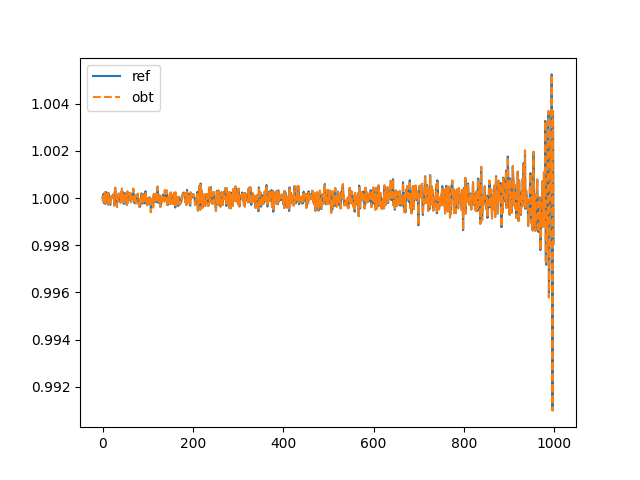

In [15]:
fig, ax = subplots()
bin = 5
ax.plot(res[0][bin][1:], label="ref")
ax.plot(d_out.get()[bin][1:], "--", label="obt")
ax.legend()

<IPython.core.display.Javascript object>


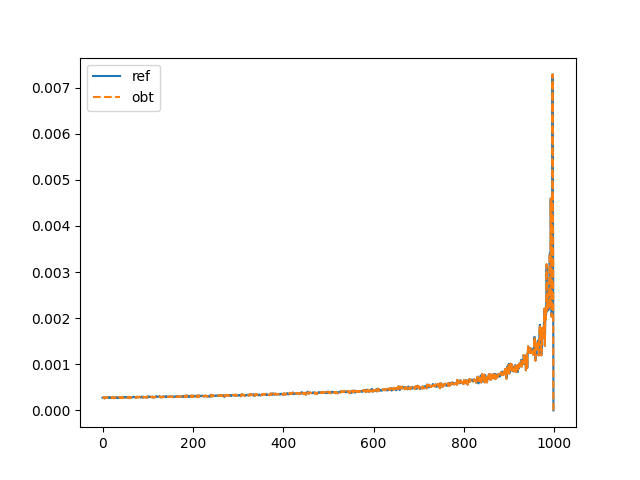

In [16]:
fig, ax = subplots()
bin = 2
ax.plot(res[1][bin][1:], label="ref")
ax.plot(d_out2.get()[bin][1:], "--", label="obt")
ax.legend()

## Perfrom the azimuthal regrouping and then use collective reduction

In this approach, the array is first re-organized to have pixels from the same Qbin grouped together to make memory access more efficient.

In a second kernel, collective reads and reduction are used to speed up execution

The drawback is that this approach almost duplicates the memory needed on the device.

In [ ]:
#TODO !